In [239]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline

In [240]:
red_df = pd.read_csv('data/winequality-red.csv', sep = ';')
white_df = pd.read_csv('data/winequality-white.csv', sep = ';')

In [241]:
red_df['wine_color'] = 'red'
white_df['wine_color'] = 'white'

In [242]:
total_wine = pd.concat([red_df, white_df], axis = 0).reset_index()
total_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
 13  wine_color            6497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 710.7+ KB


In [243]:
total_wine.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,6497.0,2042.535632,1436.926393,0.00000,812.00000,1649.00000,3273.00000,4897.00000
fixed acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000


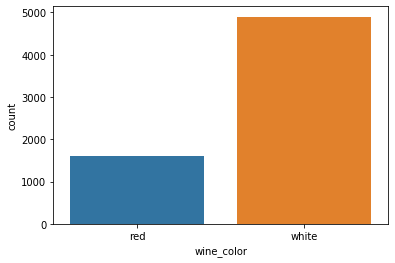

In [244]:
sns.countplot(total_wine['wine_color'])

In [245]:
total_wine.head()

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_color
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


**Large sample of white wines. This means we have an unbalanced data set.**

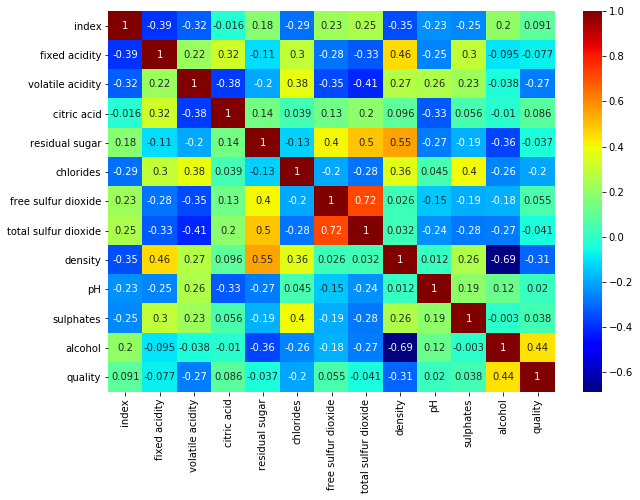

In [246]:
plt.figure(figsize = (10, 7))
sns.heatmap(total_wine.corr(), annot = True, cmap = 'jet')

In [247]:
total_wine['quality'].unique()

array([5, 6, 7, 4, 8, 3, 9], dtype=int64)

In [248]:
from collections import Counter
Counter(total_wine['quality'])

Counter({5: 2138, 6: 2836, 7: 1079, 4: 216, 8: 193, 3: 30, 9: 5})

c:\users\16238\.conda\envs\python\lib\site-packages\seaborn\axisgrid.py:728: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



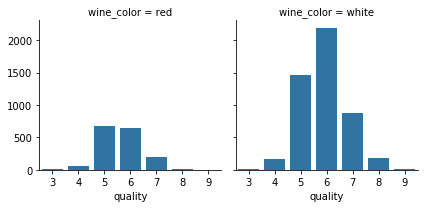

In [249]:
g = sns.FacetGrid(total_wine, col = 'wine_color')
g = g.map(sns.countplot, 'quality')

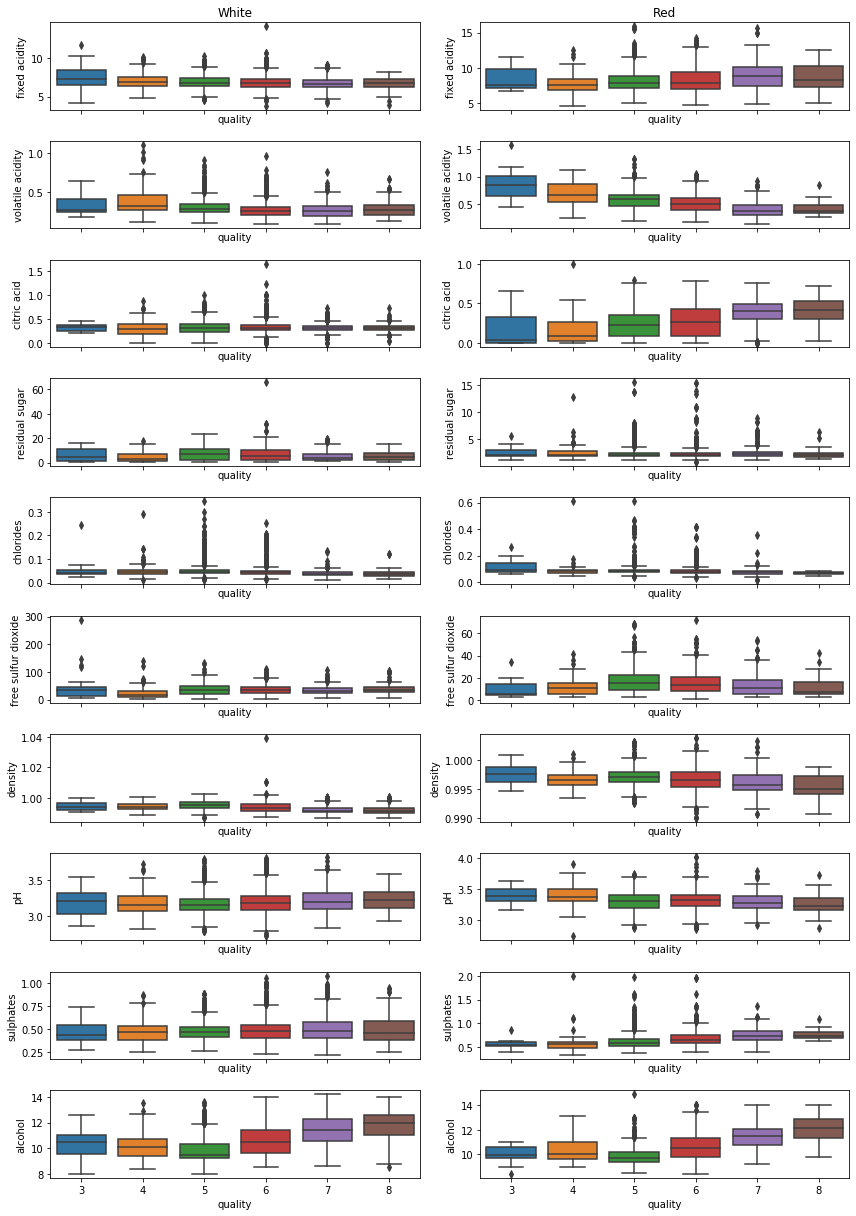

In [250]:
fig, axes = plt.subplots(10, 2, figsize = (12,17), sharex = True)

ax = sns.boxplot(x="quality", y="fixed acidity", data=white_df, orient='v', 
    ax=axes[0, 0])
ax = sns.boxplot(x="quality", y="fixed acidity", data=red_df, orient='v', 
    ax=axes[0, 1])
ax = sns.boxplot(x="quality", y="volatile acidity", data=white_df, orient='v', 
    ax=axes[1, 0])
ax = sns.boxplot(x="quality", y="volatile acidity", data=red_df, orient='v', 
    ax=axes[1, 1])
ax = sns.boxplot(x="quality", y="citric acid", data=white_df, orient='v', 
    ax=axes[2, 0])
ax = sns.boxplot(x="quality", y="citric acid", data=red_df, orient='v', 
    ax=axes[2, 1])
ax = sns.boxplot(x="quality", y="residual sugar", data=white_df, orient='v', 
    ax=axes[3, 0])
ax = sns.boxplot(x="quality", y="residual sugar", data=red_df, orient='v', 
    ax=axes[3, 1])
ax = sns.boxplot(x="quality", y="chlorides", data=white_df, orient='v', 
    ax=axes[4, 0])
ax = sns.boxplot(x="quality", y="chlorides", data=red_df, orient='v', 
    ax=axes[4, 1])
ax = sns.boxplot(x="quality", y="free sulfur dioxide", data=white_df, orient='v', 
    ax=axes[5, 0])
ax = sns.boxplot(x="quality", y="free sulfur dioxide", data=red_df, orient='v', 
    ax=axes[5, 1])
ax = sns.boxplot(x="quality", y="density", data=white_df, orient='v', 
    ax=axes[6, 0])
ax = sns.boxplot(x="quality", y="density", data=red_df, orient='v', 
    ax=axes[6, 1])
ax = sns.boxplot(x="quality", y="pH", data=white_df, orient='v', 
    ax=axes[7, 0])
ax = sns.boxplot(x="quality", y="pH", data=red_df, orient='v', 
    ax=axes[7, 1])
ax = sns.boxplot(x="quality", y="sulphates", data=white_df, orient='v', 
    ax=axes[8, 0])
ax = sns.boxplot(x="quality", y="sulphates", data=red_df, orient='v', 
    ax=axes[8, 1])
ax = sns.boxplot(x="quality", y="alcohol", data=white_df, orient='v', 
    ax=axes[9, 0])
ax = sns.boxplot(x="quality", y="alcohol", data=red_df, orient='v', 
    ax=axes[9, 1])

axes[0,0].title.set_text('White')
axes[0,1].title.set_text('Red')
plt.tight_layout()

**The boxplots show outliers for quite a few columns. Fixed acidity for red wine has a first quartile value of 7.1 with its second quartile value being 7.9. Not much of a variance which explains the huge number of outliers. White wines fixed acidity has a first quartile value of 6.3 and second quartile value of 6.8, again not much variance. Similar logic applies for volatile acidity for both types of wine. The Citric acid column seems to be uniformly distributed. The other columns red (white) are described below. Residual sugar has a minimum of 0.9 (0.6) but a maximum of 15.5 (65.8), far too much difference. Chlorides also have a huge difference with their minimum value being 0.012 (0.009) and the maximum being 0.61 (0.35). This is the case for free sulfur dioxide as well, minimum is 1 (2.0) and maximum is 72 (289).**

In [251]:
white_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [252]:
red_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


**We will categorize the wine into either red or white and then create a model to evaluate the quality for each.**

**New columns will now be created called review that will push the numbered quality measures into three categories: Bad, Average, Excellent. They will be split in the following manner.**


**1, 2, 3, 4 --> Bad (1)**


**5, 6 --> Average (2)**


**7, 8, 9, 10 --> Excellent (3)**

**Hopefully, this will distribute the unenven distribution as well since most values fall within the 4 to 7 range.**

In [253]:
def categorize(quality):
    if quality in [1, 2, 3, 4]:
        return 1
    if quality in [5, 6]:
        return 2
    if quality in [7, 8, 9 ,10]:
        return 3

red_df['review'] = red_df['quality'].apply(categorize)
white_df['review'] = white_df['quality'].apply(categorize)
total_wine['review'] = total_wine['quality'].apply(categorize)

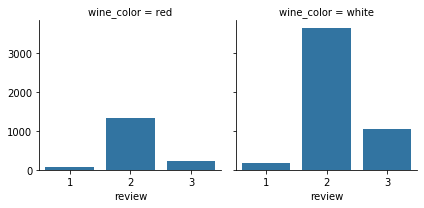

In [254]:
g = sns.FacetGrid(total_wine, col = 'wine_color')
g = g.map(sns.countplot, 'review', order = [1,2,3])

In [255]:
Counter(total_wine['quality'])

Counter({5: 2138, 6: 2836, 7: 1079, 4: 216, 8: 193, 3: 30, 9: 5})

In [256]:
Counter(total_wine['review'])

Counter({2: 4974, 3: 1277, 1: 246})

**The data is still a bit imbalanced, I'll run a few models and check precision and recall to check how much this imbalance will effect predictions. It may be better to leave the values as they are and not try and conglomerate.**

In [257]:
# 0 for red, 1 for white
total_wine['wine_color'] = pd.get_dummies(total_wine['wine_color'], drop_first = True)
total_wine['wine_color']

0       0
1       0
2       0
3       0
4       0
       ..
6492    1
6493    1
6494    1
6495    1
6496    1
Name: wine_color, Length: 6497, dtype: uint8

In [265]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [266]:
X = total_wine.drop(['wine_color', 'quality', 'review'], axis = 1)
y = total_wine['wine_color']

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [272]:
from sklearn.ensemble import RandomForestClassifier

In [269]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [270]:
predictions = rf.predict(X_test)

In [271]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       557
           1       1.00      1.00      1.00      1588

    accuracy                           1.00      2145
   macro avg       1.00      0.99      1.00      2145
weighted avg       1.00      1.00      1.00      2145

[[ 550    7]
 [   0 1588]]


**Given some wine we want to predict its color and then figure out its quality relative to it either being red or white. We will use a neural network to predict quality.**

In [277]:
from tensorflow import keras

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       557
           1       0.99      1.00      1.00      1588

    accuracy                           0.99      2145
   macro avg       0.99      0.99      0.99      2145
weighted avg       0.99      0.99      0.99      2145

